# Denoising Model Training

In [1]:
!python --version

Python 3.13.11


## Data Load and presentation

In [2]:
import gc
gc.collect()

307

In [3]:
PATCH_SIZE_2D = (64, 64)
PATCH_SIZE_3D = (32, 64, 64)
PATCH_SIZE = PATCH_SIZE_2D

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import tifffile
import numpy as np

class CalciumDataset(Dataset):
    def __init__(self, tiff_paths, patch_size=(32, 64, 64), samples_per_epoch=1000):
        self.images = []
        self.normals = []
        self.patch_size = patch_size
        self.samples_per_epoch = samples_per_epoch

        for tiff_path in tiff_paths:
            image = tifffile.imread(tiff_path)
            # lower = np.percentile(image, 1.0)
            # upper = np.percentile(image, 99.9)

            self.normals.append((-100.0, 1500.0))
            self.images.append(image)

    def __len__(self):
        return self.samples_per_epoch

    def __getitem__(self, idx):
        if len(self.patch_size) == 2:
            image_idx = np.random.randint(len(self.images))
            image = self.images[image_idx]
            lower, upper = self.normals[image_idx]
            frame = image[np.random.randint(image.shape[0])]

            h_max, w_max = frame.shape
            h_start = np.random.randint(h_max - self.patch_size[0])
            w_start = np.random.randint(w_max - self.patch_size[1])

            patch = frame[h_start:h_start+self.patch_size[0], w_start:w_start+self.patch_size[1]]
            patch = np.clip(patch, lower, upper)
            patch = (patch - lower) / (upper - lower + 1e-8)
            patch_tensor = torch.from_numpy(patch).unsqueeze(0).float()

            masked_patch, mask = self.n2v_mask(patch_tensor)
            return masked_patch, mask, patch_tensor
        elif len(self.patch_size) == 3:
            raise NotImplementedError("3D patches not implemented")
        else:
            raise ValueError("Invalid patch size")

    def n2v_mask(self, img):

        mask_ratio = 0.015

        rand_tensor = torch.rand(img.shape)
        mask = rand_tensor < mask_ratio

        masked_img = img.clone()
        fill_values = torch.randn(mask.sum()) * img.std() + img.mean()
        masked_img[mask] = fill_values

        return masked_img, mask

import pathlib

train_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/train")
valid_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/valid")
train_paths = list(train_path.glob("*.tif"))
valid_paths = [p for p in valid_path.glob("*.tif") if "f0" not in p.name.lower()]
ground_truth = tifffile.imread("/content/drive/MyDrive/public/ai4life-cidc2025/valid/F0.tif")

print(len(train_paths), len(valid_paths))

train_dataset = CalciumDataset(train_paths, patch_size=PATCH_SIZE, samples_per_epoch=8000)
valid_dataset = CalciumDataset(valid_paths, patch_size=PATCH_SIZE, samples_per_epoch=2000)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2)

4 3


In [ ]:
for data in train_dataset.normals:
    print(data)
    # print(data.shape, data.max(), data.min())

(-100.0, 1500.0)
(-100.0, 1500.0)
(-100.0, 1500.0)
(-100.0, 1500.0)


## Model architecture


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)


    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = F.resize(x, size=skip_connection.shape[2:], mode="bilinear", align_corners=True)
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

class UNet3D(nn.Module):
    def __init__(self):
        super().__init__()

class UNetnmODE(nn.Module):
    def __init__(self):
        super().__init__()

# if __name__ == "__main__":
#     x = torch.randn((1, 1, 64, 64))
#     model = UNet(in_channels=1, out_channels=1)
#     preds = model(x)
#     print(preds.shape)
#     print(x.shape)
#     assert preds.shape == x.shape
#     print("Passed")

## Model training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_one_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()

    loop = tqdm(data_loader, leave=True)
    losses = []
    for batch_idx, (masked, mask, target) in enumerate(loop):
        masked = masked.to(device)
        mask = mask.to(device)
        target = target.to(device)

        output = model(masked)
        loss = loss_fn(output[mask], target[mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

    loop.set_postfix(loss=np.mean(losses))
    return np.mean(losses)

def evaluate(model, data_loader, loss_fn, device):
    model.eval()

    loop = tqdm(data_loader, leave=True)
    losses = []
    for batch_idx, (masked, mask, target) in enumerate(loop):
        masked = masked.to(device)
        mask = mask.to(device)
        target = target.to(device)

        with torch.no_grad():
            output = model(masked)
            loss = loss_fn(output[mask], target[mask])
            losses.append(loss.item())

        loop.set_postfix(loss=loss.item())

    loop.set_postfix(loss=np.mean(losses))
    return np.mean(losses)

model = UNet(in_channels=1, out_channels=1)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_loss = float("inf")
best_model = None

for epoch in range(20):
    train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    valid_loss = evaluate(model, valid_loader, loss_fn, device)
    print(f"Epoch: {epoch}, Valid Loss: {valid_loss}")
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_model = model.state_dict()
        torch.save(best_model, "best_model.pth")

100%|██████████| 125/125 [00:05<00:00, 22.02it/s, loss=0.0118]
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 13/13 [00:00<00:00, 45.96it/s, loss=0.0217]


Epoch: 0, Valid Loss: 0.0325457607037746


100%|██████████| 13/13 [00:00<00:00, 53.03it/s, loss=0.0159]


Epoch: 1, Valid Loss: 0.03403948018184075


100%|██████████| 13/13 [00:00<00:00, 52.83it/s, loss=0.0471]


Epoch: 2, Valid Loss: 0.03236102943237011


100%|██████████| 13/13 [00:00<00:00, 52.95it/s, loss=0.0132]


Epoch: 3, Valid Loss: 0.030790905038324688


100%|██████████| 13/13 [00:00<00:00, 35.40it/s, loss=0.0201]


Epoch: 4, Valid Loss: 0.027764219145935316


100%|██████████| 13/13 [00:00<00:00, 52.65it/s, loss=0.0135]


Epoch: 5, Valid Loss: 0.026838860617807277


100%|██████████| 13/13 [00:00<00:00, 51.38it/s, loss=0.0326]


Epoch: 6, Valid Loss: 0.029454822437121317


100%|██████████| 13/13 [00:00<00:00, 38.01it/s, loss=0.0354]


Epoch: 7, Valid Loss: 0.029125917273072097


100%|██████████| 13/13 [00:00<00:00, 50.47it/s, loss=0.0438]


Epoch: 8, Valid Loss: 0.035759468777821615


100%|██████████| 13/13 [00:00<00:00, 54.00it/s, loss=0.0251]


Epoch: 9, Valid Loss: 0.028908389835403517


100%|██████████| 13/13 [00:00<00:00, 32.26it/s, loss=0.0511]


Epoch: 10, Valid Loss: 0.03215963307481546


100%|██████████| 13/13 [00:00<00:00, 53.22it/s, loss=0.0445]


Epoch: 11, Valid Loss: 0.03119774291721674


100%|██████████| 13/13 [00:00<00:00, 52.23it/s, loss=0.0202]


Epoch: 12, Valid Loss: 0.027533853856416848


100%|██████████| 13/13 [00:00<00:00, 37.62it/s, loss=0.0251]


Epoch: 13, Valid Loss: 0.02810066809447912


100%|██████████| 13/13 [00:00<00:00, 52.13it/s, loss=0.0271]


Epoch: 14, Valid Loss: 0.029703102002923306


100%|██████████| 13/13 [00:00<00:00, 52.81it/s, loss=0.022]


Epoch: 15, Valid Loss: 0.032861543676027886


100%|██████████| 13/13 [00:00<00:00, 37.23it/s, loss=0.0186]


Epoch: 16, Valid Loss: 0.03076917936022465


100%|██████████| 13/13 [00:00<00:00, 50.06it/s, loss=0.0152]


Epoch: 17, Valid Loss: 0.02985680289566517


100%|██████████| 13/13 [00:00<00:00, 52.11it/s, loss=0.0284]


Epoch: 18, Valid Loss: 0.029083878375016727


100%|██████████| 13/13 [00:00<00:00, 33.72it/s, loss=0.0466]

Epoch: 19, Valid Loss: 0.03499157039018778


# Full Images Evaluation

## Denoising validation dataset

In [ ]:
import torch.nn.functional as F
from tqdm import tqdm

def denoise_frame(model, frame, device, patch_size, slide_window=16, batch_size=16):
    model.eval()
    if len(patch_size) != 2:
        raise ValueError("Patch size must be a tuple of length 2")

    frame = frame.unsqueeze(0).unsqueeze(0).float()

    padding_frame = F.pad(frame, (slide_window, slide_window, slide_window, slide_window), mode='reflect')
    padding_frame = padding_frame.to(device)

    output_sum = torch.zeros_like(padding_frame)
    count_map = torch.zeros_like(padding_frame)

    batch_patches = []
    batch_coords = []

    _, _, h_pad, w_pad = padding_frame.shape

    with torch.no_grad():
        denoised_frame = torch.zeros_like(padding_frame)
        for h in range(0, padding_frame.shape[2] - patch_size[0] + 1, slide_window):
            for w in range(0, padding_frame.shape[3] - patch_size[1] + 1, slide_window):
                patch = padding_frame[:, :, h:h+patch_size[0], w:w+patch_size[1]]
                batch_patches.append(patch)
                batch_coords.append((h, w))

                if len(batch_patches) == batch_size:
                    batch_patches = torch.cat(batch_patches, dim=0)
                    denoised_batch = model(batch_patches)
                    for i, (ph, pw) in enumerate(batch_coords):
                        output_sum[:,:,ph:ph+patch_size[0], pw:pw+patch_size[1]] += denoised_batch[i]
                        count_map[:,:,ph:ph+patch_size[0], pw:pw+patch_size[1]] += 1
                    batch_patches = []
                    batch_coords = []
                # denoised_patch = model(patch)
                # output_sum[:, :, h:h+patch_size[0], w:w+patch_size[1]] += denoised_patch
                # count_map[:, :, h:h+patch_size[0], w:w+patch_size[1]] += 1
                # denoised_frame[:,:,h:h+patch_size[0], w:w+patch_size[1]] = denoised_patch
        if len(batch_patches) > 0:
            batch_patches = torch.cat(batch_patches, dim=0)
            denoised_batch = model(batch_patches)
            for i, (ph, pw) in enumerate(batch_coords):
                output_sum[:,:,ph:ph+patch_size[0], pw:pw+patch_size[1]] += denoised_batch[i]
                count_map[:,:,ph:ph+patch_size[0], pw:pw+patch_size[1]] += 1

        count_map[count_map == 0] = 1.0
        denoised_frame = output_sum / count_map
        denoised_frame = denoised_frame[:, :, slide_window:-slide_window, slide_window:-slide_window]
    return denoised_frame

def denoise_multi_frame(model, frames, device, patch_size, slide_window=16, batch_size=16):
    model.eval()

    denoised_frames = torch.zeros_like(frames)
    loop = tqdm(range(frames.shape[0]), leave=True)
    for t in loop:
        frame = frames[t].to(device)
        denoised_frame = denoise_frame(model, frame, device, patch_size, slide_window, batch_size)
        denoised_frames[t] = denoised_frame
    # print(denoised_frame)
    return denoised_frames

def denoise_video(model, video, device, patch_size):
    model.eval()
    with torch.no_grad():
        denoised_video = torch.zeros_like(video)
        loop = tqdm(range(video.shape[0]), leave=True)
        for t in loop:
            frame = video[t].to(device)
            denoised_frame = torch.zeros_like(frame)
            for h in range(0, frame.shape[0] - patch_size[0], patch_size[0]):
                for w in range(0, frame.shape[1] - patch_size[1], patch_size[1]):
                    patch = frame[h:h+patch_size[0], w:w+patch_size[1]]
                    patch = patch.unsqueeze(0).unsqueeze(0).float().to(device)
                    denoised_patch = model(patch)
                    denoised_frame[h:h+patch_size[0], w:w+patch_size[1]] = denoised_patch
            denoised_video[t] = denoised_frame
    return denoised_video

# Instantiate the model again
model_eval = UNet(in_channels=1, out_channels=1)
# Load the best weights
model_eval.load_state_dict(best_model)
model_eval.to(device)
model_eval.eval()

denoised_videos = []
for video in valid_dataset.images:
    video = torch.from_numpy(video).to(device)
    print(video.shape)
    # denoised_video = denoise_video(model, video, device, (64, 64))
    denoised_video = denoise_multi_frame(model_eval, video, device, PATCH_SIZE, 32, 256)
    denoised_videos.append(denoised_video.squeeze(0).squeeze(0).cpu().numpy())

denoised_videos[0][0]

torch.Size([1500, 490, 490])


100%|██████████| 1500/1500 [09:26<00:00,  2.65it/s]


torch.Size([1500, 490, 490])


100%|██████████| 1500/1500 [09:25<00:00,  2.65it/s]


torch.Size([1500, 490, 490])


100%|██████████| 1500/1500 [09:24<00:00,  2.66it/s]


array([[475, 401, 411, ..., 214, 234, 197],
       [439, 579, 459, ..., 271, 248, 226],
       [438, 524, 483, ..., 254, 254, 253],
       ...,
       [230, 310, 287, ..., 526, 499, 578],
       [237, 265, 358, ..., 444, 519, 494],
       [259, 310, 296, ..., 458, 478, 514]], dtype=int16)

## Evaluate SNR

In [ ]:
def calc_snr(clean, noisy, eps=1e-8):
    signal = np.mean(clean ** 2)
    noise = np.mean((clean - noisy) ** 2)
    if signal == 0:
        return 0.0
    return 10 * np.log10(signal / (noise + eps))

def calc_metrics(clean_video, denoised_video, alpha=0.5, eps=1e-8):

    T, H, W = clean_video.shape

    # --- 1. 初始化容器 ---
    # sSNR: 我們只需要存每一幀算出的一個純量數值 (Scalar)
    s_snr_list = []

    # tSNR: 我們需要兩個 (H, W) 的累加器，用來存總和
    # 使用 float64 以避免累加過程溢位
    acc_pixel_signal_sq = np.zeros((H, W), dtype=np.float64)
    acc_pixel_noise_sq = np.zeros((H, W), dtype=np.float64)

    # --- 2. 逐幀迴圈 (Streaming Loop) ---
    for t in range(T):
        # 取出一幀 (這樣只佔用一張圖的 RAM)
        # 轉成 float64 確保運算精度
        frame_clean = clean_video[t].astype(np.float64)
        frame_restored = denoised_video[t].astype(np.float64)

        # 算出這一幀的誤差
        frame_noise = frame_clean - frame_restored

        # --- A. 處理 sSNR (Spatial) ---
        # 針對這單一幀算 SNR
        f_sig_pow = np.mean(frame_clean ** 2)
        f_ns_pow = np.mean(frame_noise ** 2)

        if f_sig_pow > eps:
            s_snr_val = 10 * np.log10(f_sig_pow / (f_ns_pow + eps))
        else:
            s_snr_val = 0.0 # 若該幀全黑

        s_snr_list.append(s_snr_val)

        # --- B. 處理 tSNR (Temporal) ---
        # 把這一幀的平方值「累加」到蓄水池裡
        acc_pixel_signal_sq += (frame_clean ** 2)
        acc_pixel_noise_sq += (frame_noise ** 2)

    # --- 3. 迴圈結束，計算最終結果 ---

    # A. sSNR 結果: 直接平均列表
    s_snr = np.mean(s_snr_list)

    # B. tSNR 結果:
    # 先算出平均功率 (除以時間 T)
    pixel_signal_power = acc_pixel_signal_sq / T
    pixel_noise_power = acc_pixel_noise_sq / T

    # 逐像素計算 dB
    valid_pixels = pixel_signal_power > eps
    pixel_snr_vals = np.zeros_like(pixel_signal_power)

    pixel_snr_vals[valid_pixels] = 10 * np.log10(
        pixel_signal_power[valid_pixels] / (pixel_noise_power[valid_pixels] + eps)
    )

    t_snr = np.mean(pixel_snr_vals)

    # C. stSNR 結果
    st_snr = alpha * s_snr + (1 - alpha) * t_snr

    return s_snr, t_snr, st_snr

In [ ]:
metrics = []
for i in range(len(denoised_videos)):
    metrics.append(calc_metrics(ground_truth, denoised_videos[i]))
metrics

[(np.float64(4.251183822880931),
  np.float64(3.2060287352956194),
  np.float64(3.7286062790882752)),
 (np.float64(-1.1372184403904348),
  np.float64(-2.37948105393699),
  np.float64(-1.7583497471637126)),
 (np.float64(9.312086491219613),
  np.float64(9.305178047750221),
  np.float64(9.308632269484917))]

## Show denoising images

In [ ]:
from matplotlib import axes
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def interact_viewer(gt, noised, denoised):
    vmin, vmax = np.percentile(gt, (2, 70))
    # vmin, vmax = gt.min(), gt.max()
    print(vmin, vmax)

    def view_frame(t):
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        axs[0, 0].imshow(gt[t], cmap='gray', vmin=vmin, vmax=vmax)
        axs[0, 0].set_title(f"Gound Truth (t={t})")
        axs[0, 0].axis('off')

        axs[0, 1].axis('off')

        axs[1, 0].imshow(noised[t], cmap='gray', vmin=vmin, vmax=vmax)
        axs[1, 0].set_title(f"Noised (t={t})")
        axs[1, 0].axis('off')

        axs[1, 1].imshow(denoised[t], cmap='gray', vmin=vmin, vmax=vmax)
        axs[1, 1].set_title(f"Denoised (t={t})")
        axs[1, 1].axis('off')

        plt.show()

    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(gt)-1,
        step=1,
        description='Time Frame:'
    )

    widgets.interact(view_frame, t=slider)

interact_viewer(ground_truth, valid_dataset.images[0], denoised_videos[0])
# interact_viewer(valid_dataset.images[0], valid_dataset.images[1])

75.0 239.0


interactive(children=(IntSlider(value=0, description='Time Frame:', max=1499), Output()), _dom_classes=('widge…

[F0 (GT)] Min: 0.0000, Max: 4277.0000, Mean: 193.1924, Median: 183.0000
[F1 (Noisy)] Min: -233.0000, Max: 4483.0000, Mean: 192.9887, Median: 161.0000
[Denoised] Min: 22.0000, Max: 4135.0000, Mean: 312.9139, Median: 300.0000


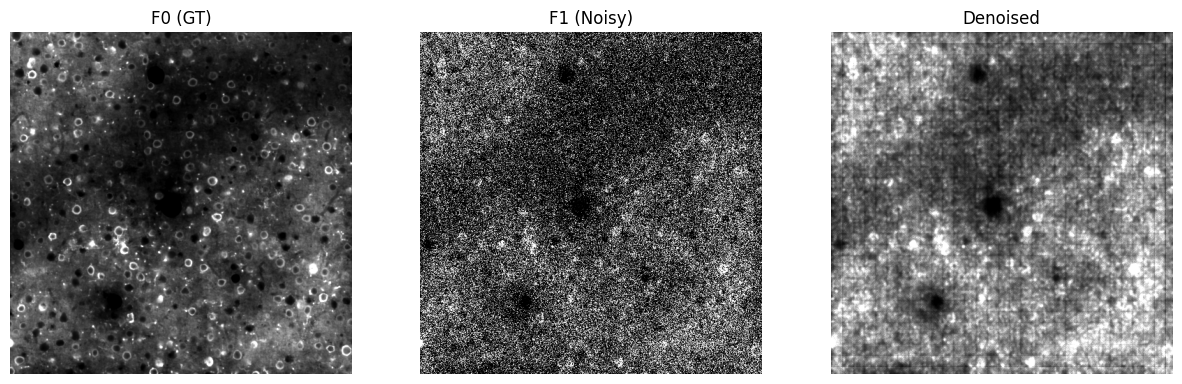

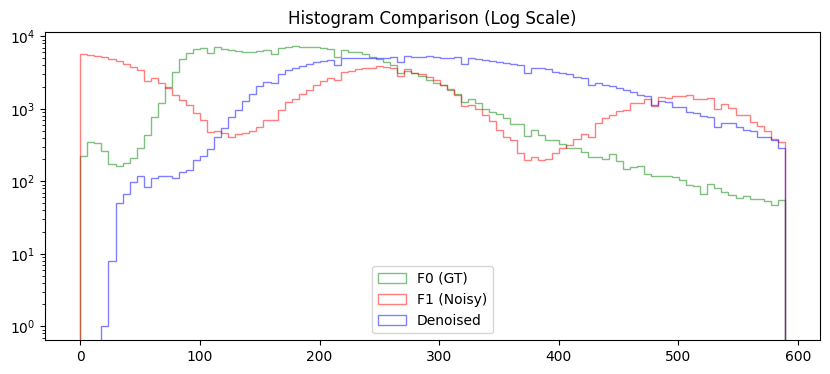

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def inspect_brightness(f0, f1, denoised):
    """
    輸入三個影像 (假設都是 Numpy Array)
    """
    imgs = [f0[0], f1[0], denoised[0]]
    names = ['F0 (GT)', 'F1 (Noisy)', 'Denoised']

    plt.figure(figsize=(15, 5))

    for i, (img, name) in enumerate(zip(imgs, names)):
        # 1. 印出統計數值 (最準確)
        print(f"[{name}] Min: {img.min():.4f}, Max: {img.max():.4f}, Mean: {img.mean():.4f}, Median: {np.median(img):.4f}")

        # 2. 畫圖 (用同樣的 vmin/vmax 比較才公平)
        # 我們統一用 F0 的標準來看
        vmin, vmax = np.percentile(f0, (1, 99.5))

        plt.subplot(1, 3, i+1)
        plt.title(name)
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        plt.axis('off')

    plt.show()

    # 3. 畫直方圖 (檢查背景有沒有偏移)
    plt.figure(figsize=(10, 4))
    plt.title("Histogram Comparison (Log Scale)")
    for img, name, color in zip(imgs, names, ['green', 'red', 'blue']):
        # flatten 拉平，bins 設多一點
        plt.hist(img.flatten(), bins=100, range=(np.percentile(f0, 0), np.percentile(f0, 99.5)),
                 alpha=0.5, label=name, color=color, log=True, histtype='step')
    plt.legend()
    plt.show()

inspect_brightness(ground_truth, valid_dataset.images[0], denoised_videos[0])